# **Собираем CLIP: Обучение без Обучения. Классификатор животных из мультфильмов. Без данных и за 5 минут. Colab**

# 🤖🎓 **[Телеграм-канал «Мишин Лернинг»](https://t.me/mishin_learning)**
# 🎓🎬   **[«Мишин Лернинг» ❗️ YouTube](https://www.youtube.com/channel/UCPJBmNpgyte-aVvPXJG1yVQ)**






![Google's logo](https://habrastorage.org/webt/1_/qc/xv/1_qcxv2ete1ebauolcch-n4okfa.png)

*   **Подготовка Colab**. Установка PyTorch 1.7.1.
*   **Загружаем CLIP**. Загружаем Нейронную Сеть.
*   **Препроцессинг данных**. Разбираем препроцессинг изображений и текстов.
*   **Обучение без Обучения**. Получаем классификатор в режиме "обучение без обучения"
*   **Результаты**. Смотрим и анализируем примеры классификации.




# Подготовка Colab

Убедитесь, что вы используете runtime c графическим процессором. Если нет, то выберите «GPU» в качестве аппаратного ускорителя в в меню Runtime > Change Runtime Type.

 После запуска блока нас ждет установка PyTorch 1.7.1.



In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 10.1


In [ ]:
! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

Torch version: 1.7.1+cu101


# Загружаем CLIP

Скачиваем CLIP, предобученный на 400М пар изображение-текст.  Его можно использовать в режиме обучения без обучения (например ViT-B/32 CLIP). После запуска блока нас ждет установка скачивание model.pt модели CLIP: Visual Transformer "ViT-B/32" + Text Transformer

In [ ]:
MODELS = {
    "ViT-B/32":       "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}

In [ ]:
! wget {MODELS["ViT-B/32"]} -O model.pt

--2021-01-31 23:33:48--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.13, 2620:1ec:bdf::13
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘model.pt’

model.pt            100%[===================>] 337.58M  61.4MB/s    in 5.6s    

2021-01-31 23:33:54 (60.2 MB/s) - ‘model.pt’ saved [353976522/353976522]



In [ ]:
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Препроцессинг Изображений

Так как модель CLIP представляет из себя Visual Transformer "ViT-B/32", это означает, что вход модели должен быть фиксированного разрешения 224x224 пикселя. Препроцессинг изображений представляет из себя изменение размера входного изображения и обрезка его по центру. Перед этим нормализуем яркость пикселей картинки, используя поканальное  среднее значение датасета 400М пар изображение-текст и стандартное отклонение.



In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

# Препроцессинг Текста

Текстовый препроцессинг для Text Transformer части сети CLIP использует  без нечувствительный к регистру токенизатор. Код токенизатора скрыт во второй ячейке блока. Далее текст паддится до длины сontext length, и готов подаваться в трансформер.

In [ ]:
! pip install ftfy regex
! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz

--2021-01-31 23:34:07--  https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.13, 2620:1ec:bdf::13
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1356917 (1.3M) [application/octet-stream]
Saving to: ‘bpe_simple_vocab_16e6.txt.gz’

bpe_simple_vocab_16 100%[===================>]   1.29M  --.-KB/s    in 0.05s   

2021-01-31 23:34:07 (28.0 MB/s) - ‘bpe_simple_vocab_16e6.txt.gz’ saved [1356917/1356917]



In [ ]:
#@title

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text


# Подготовка к обучению без обучения

Перед непосредственным обучением без обучения, давайте разберем на примере, как работает CLIP. 

Давайте  скормим модели 10 изображений по одному примеру на класс и их текстовые описания. А потом построим матрицу косинусных расстояний между векторами изображений и векторами текстов (cosine similarity в общем пространстве визуальных и текстовых репрезентаций). 

### Ссылки на изображения

In [ ]:
dog_list = [
        "https://static.wikia.nocookie.net/disney/images/0/06/Profile_-_Lady.jpeg/revision/latest?cb=20190314123153",
        "https://www.artnet.com/WebServices/images/ll00219lld1FRJFg03G72CfDrCWvaHBOcn1GF/walt-disney-studios-a-celluloid-of-tramp-from-lady-and-the-tramp.jpg",
        "https://www.artnet.com/WebServices/images/ll00218lld1FRJFg03G72CfDrCWvaHBOcn1GF/walt-disney-studios-a-celluloid-of-lady-from-lady-and-the-tramp.jpg",
        "https://99px.ru/sstorage/53/2017/09/tmb_208485_1751.jpg",
        "https://mults.info/screen/pes_v_sapogah.jpg",
        "https://i.ytimg.com/vi/cedt81xIj3Q/hqdefault.jpg",
        "https://static.wikia.nocookie.net/adventuretimewithfinnandjake/images/2/2a/Hotdogpeople.png/revision/latest?cb=20120416091001",
        "https://lostpic.net/orig_images/1/f/c/1fca26ebc685f043485c42788815b9f7.png",
        "https://s4.cdn.teleprogramma.pro/wp-content/uploads/2018/03/2715856a35af29d0f8c46bf0ca786e29.jpg",
        "https://img1.looper.com/img/gallery/adventure-time-distant-lands-hints-at-the-death-of-a-fan-favorite-character/intro-1606155312.jpg",
        "https://i.pinimg.com/originals/35/00/f0/3500f0ea8dc332f61a91a5246f43317e.jpg"
        ]

cat_list = [
        "https://cs6.pikabu.ru/images/previews_comm/2015-05_2/1431288516433.jpg",
        "https://citaty.info/files/screenshot_25_0.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR4wFdichLCRxqSw4uJbWpzwxyIopTm6hj7OQ&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR2NV3JGz4zV31iYQhHwVgREcs2Mb6aiE12qA&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS3dAdQaiILpBRX_HvVVHku0WHMzH6K287t5g&usqp=CAU",
        "https://dasound.net/assets/img/people/Matroskin_Kot_19.jpg",
        "https://1.bp.blogspot.com/-Cj98zwDFl-0/Tbiv_tQQ6aI/AAAAAAAAokg/tZnQ8rb1LJ0/s1600/Butch-Cartoon-Photos.jpg",
        "https://i.pinimg.com/originals/d6/74/00/d67400a2fa067bb94e806f8991bc82a9.png",
        "https://topm.3dn.ru/gav1.0-04-13.jpg",
        "https://coub-anubis-a.akamaized.net/coub_storage/coub/simple/cw_timeline_pic/7b51cf5458c/eae8e590cc617e39a9b5b/1473416685_image.jpg",
        "https://ic.pics.livejournal.com/marinagra/32470728/1587945/1587945_original.jpg",
        ]

mice_list = [
        "https://media.tenor.com/images/92dbae244846ba2f79e905c5463cca92/tenor.png",
        "https://mults.info/screen/myszka_08_koncert_swierszcza.jpg",
        "https://img1.goodfon.ru/wallpaper/nbig/3/ad/multfilm-ratatuy-mysh.jpg",
        "https://thumbs.gfycat.com/CheapSmugFlies-poster.jpg",
        "https://www.collegefashion.net/wp-content/uploads/2019/01/steamboat-willie.jpg",
        "https://i.pinimg.com/originals/03/df/6b/03df6b1380d53eff6077638862e6f869.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSh41fJ_QxxghmVRcgrVzktr2tXwGZM7BgJxA&usqp=CAU",
        ]   

penguin_list = [
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRcFMVpGddNuiiCl4ilcV5GIAOg8AATAk9joA&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSxXNBxwUGYC5WF_4f648smIslDPBSuup4-7g&usqp=CAU",
        "https://i.ytimg.com/vi/i5aD4FDl9xQ/hqdefault.jpg",
        "https://b1.filmpro.ru/c/280707.700xp.jpg",
        "https://i.mycdn.me/image?id=837524859811&t=50&plc=WEB&tkn=*2l2XEJwKqQSjwuPneOrldOSX4T8&fn=external_8",
        "https://img.gazeta.ru/files3/553/6322553/Penguins-of-Madagascar-2510553-pic700-700x467-20070.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQVVbNdeEafabrihdfBWjRnHwxJ27pe6o6ISQ&usqp=CAU",
        "https://cdnimg.rg.ru/i/gallery/b33a8c9f/7_76035374.jpg",
        ]

deer_list = [
        "https://jewish.ru/culture/cinema/2013/12/bambi.jpg",
        "https://films7.zagonka.tv/uploads/vd/230000/229854/screen_3.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRrLXwwXu1VqSHKz6qFTLeQyNafC4jDVU841w&usqp=CAU",
        "https://i.pinimg.com/originals/84/ea/21/84ea21239cbbb349c86438021efb9f04.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS2FKAmZFflAmF3x7TF4dIlyZttjhDZhs2odw&usqp=CAU",
        ]

pig_list = [
        "https://cs6.pikabu.ru/images/big_size_comm/2015-06_5/1434900465147582999.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSK_kH50T_mJJf42SxYYpqTDq3QBdzDoXazEw&usqp=CAU",
        "https://i.pinimg.com/originals/9d/b3/a4/9db3a479adfd6c9f9073bf239d735f57.jpg",
        "https://www.supercartoons.net/images/cartoons/i-havent-got-a-hat.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTqb-KXeEuK7krA0lspmEtAUHB6FoQaYbGwmQ&usqp=CAU",
        ]

fox_list = [
        "https://russkaja-skazka.ru/wp-content/uploads/2016/08/kolobok-chitat-skazki-s-krasochnyimi-kartinkami-russkaja-skazka-min.jpg",
        "https://s00.yaplakal.com/pics/pics_original/9/7/2/8830279.jpg",
        "https://i.pinimg.com/originals/23/f5/ab/23f5abb963425201a60ae75c649769a5.jpg",
        "https://www.meme-arsenal.com/memes/6a33550feeb673ddc2bfd948a0cf0d4c.jpg",
        ]

bunny_list = [
        "https://slovnet.ru/wp-content/uploads/2019/10/1-56.jpg",
        "https://i.pinimg.com/736x/43/36/3e/43363e92b72ae1a176f4da37a2d98d9c.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZ4vAXbaSboUxHPq36Ti7X01wN1zL5tEquOw&usqp=CAU",
        "https://mult-online.ru/posters/260_347_90_1/uploads/posts/2011-05/thumbs/1305554431_zayac-iz-nu-pogodi.jpg",
        ]

wolf_list = [
        "https://pbs.twimg.com/media/EWug5j5X0AAdquu.jpg:large",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSnrjUbgx0T6qniCkO8m6-6wDmn1rzM2hy0OA&usqp=CAU",
        "https://pobedarf.ru/wp-content/uploads/2020/06/volk.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQL8WJitB_yODJK06J4vjmRtVFG8iX5Uj-rqg&usqp=CAU",
        ]

lion_list = [
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQYAPtYJJP4qcqJB3duR4-Mnk9at8VGq_Nb4g&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRFLJdo3JEE9lY_goArQy0nRBIgZXVefB8c3g&usqp=CAU",
        "https://i.pinimg.com/originals/d5/85/c7/d585c741a26d76d0a0a49a01c1ce33db.jpg",
        "https://i.pinimg.com/originals/1d/d6/e8/1dd6e82e565b95d2c623282d94ec70d7.jpg",
        "https://vdp.mycdn.me/getImage?id=129185155839&idx=11&thumbType=32",
        ]

### Скачаем тестовые изображения и возьмем по одному примеру из каждого класса

In [ ]:
from PIL import Image
import requests

per_class_lists = [dog_list, cat_list, mice_list, penguin_list, deer_list,
                   pig_list, fox_list, bunny_list, wolf_list, lion_list]

images = []
one_per_class = []

for per_class_list in per_class_lists:
    for id, url in enumerate(per_class_list):
        try:
            im = Image.open(requests.get(url, stream=True).raw)
            image = preprocess(im)
            if image.shape[0] != 3:
                raise TypeError("Only 3-channel RGB image are allowed")
            images.append(image)
            if id == 0:
                one_per_class.append(image)
        except:
            print(f"error: {id}, {url}")


In [ ]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

descriptions = {
    "Dog": "This is a painting of cartoon dog",
    "Cat": "This is a painting of cartoon cat",
    "Mice": "This is a painting of cartoon rat or mice",
    "Penguin": "This is a painting of cartoon penguin",
    "Deer": "This is a painting of cartoon deer",
    "Pig": "This is a painting of cartoon pig",
    "Fox": "This is a painting of cartoon fox",
    "Bunny": "This is a painting of cartoon hare or bunny", 
    "Wolf": "This is a painting of cartoon wolf",
    "Lion": "This is a painting of cartoon lion"
}

texts = [descriptions[key] for key in descriptions]

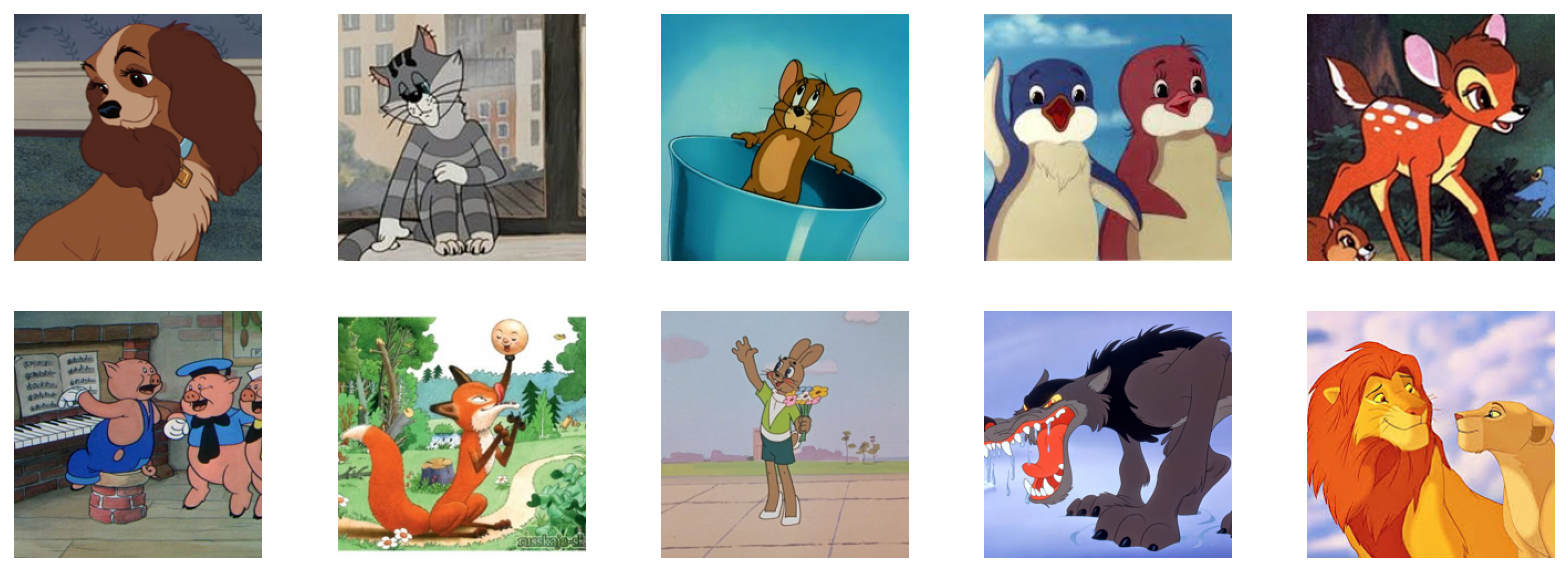

In [ ]:
plt.figure(figsize=(14, 5))

for i, (image, key) in enumerate(zip(one_per_class, descriptions)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")


## Получаем векторные репрезентации изображений и текстовых описаний

In [ ]:
image_input = torch.tensor(np.stack(one_per_class)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

In [ ]:
tokenizer = SimpleTokenizer()
text_tokens = [tokenizer.encode(desc) for desc in texts]

In [ ]:
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']

for i, tokens in enumerate(text_tokens):
    tokens = [sot_token] + tokens + [eot_token]
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_input).float()

## Cosine similarity

Как мы видим, по матрице cosine similarity, максимальная схожесть векторных  репрезентаций изображений и текстовых описаний находится на главной диагонали. Из этого мы можем сделать вывод, что CLIP подходит под нашу задачу.

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

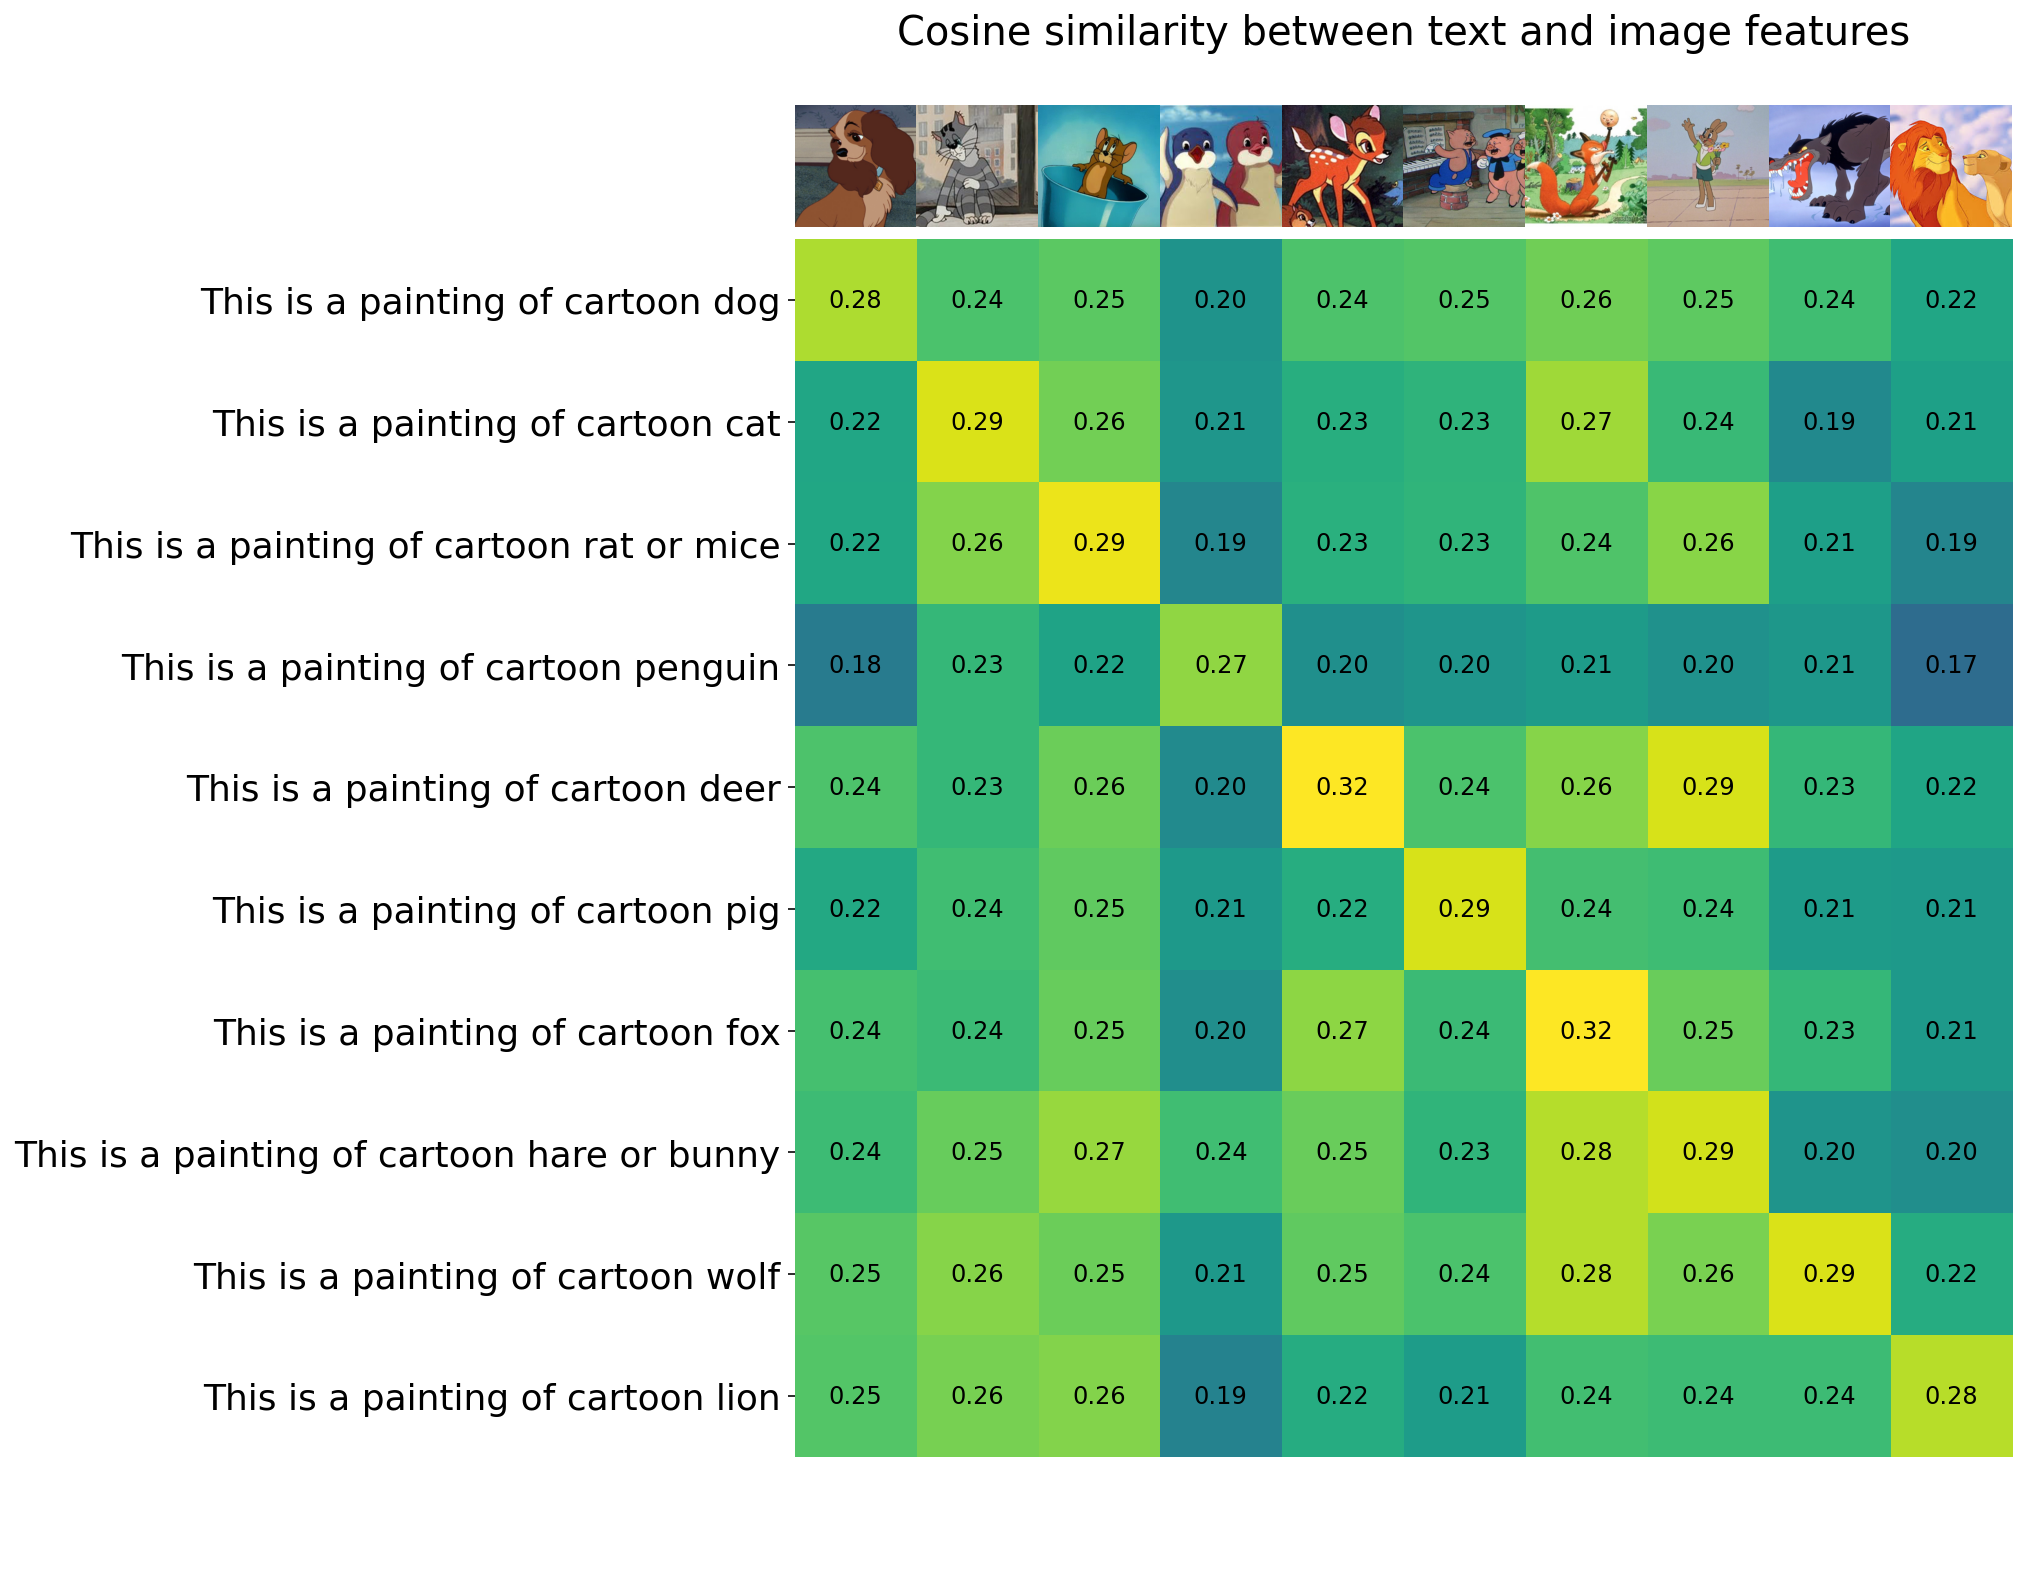

In [ ]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(one_per_class):
    plt.imshow(image.permute(1, 2, 0), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Обучение без обучения

Так как же получить классификатор под свою задачу в режиме обучения без обучения?На самом деле мы его уже получили. Ведь если cosine similarity векторных репрезентаций изображений и текстовых описаний максимальна у правильных пар изображение-текст, то все что нам нужно это прогнать тексты и изображения и найти для каждой картинки текст, чья векторная репрезентация будет ближе всего. Это и есть классификация. Но нам не нужно прогонять текст каждый раз, для каждого вызова классификатора. Мы можем сделать это один раз и получить готовый классификатор. Теперь осталось прогнать эти текстовые описания через Text Transformer и забрть векторные репрезентации. 

In [ ]:
text_descriptions = ["This is a painting of cartoon dog", 
                     "This is a painting of cartoon cat",
                     "This is a painting of cartoon rat or mice",
                     "This is a painting of cartoon penguin",
                     "This is a painting of cartoon deer",
                     "This is a painting of cartoon pig",
                     "This is a painting of cartoon fox",
                     "This is a painting of cartoon hare or bunny",
                     "This is a painting of cartoon wolf",
                     "This is a painting of cartoon lion",
                     ]

In [ ]:
image_input = torch.tensor(np.stack(images)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

In [ ]:
text_tokens = [[sot_token] + tokenizer.encode(desc) + [eot_token] for desc in text_descriptions]
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()
text_input.shape

torch.Size([10, 77])

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    image_features /= image_features.norm(dim=-1, keepdim=True) # 512 -> 256 -> 1 (1/0) (N -> 512)
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(3, dim=-1)

# Результаты

In [ ]:
plt.figure(figsize=(25, 60))

for i, image in enumerate(images):
    plt.subplot(17, 8, 2 * i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(17, 8, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [text_descriptions[index].split(' ')[-1] for index in top_labels[i].numpy()])
    # plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()